# Alignment

Alignment is the process by which feature coordinates across samples are adjusted to account for instrument variation (drift, calibration, etc.) such that matching features are aligned to adjust for small differences in coordinates. 
To perform alignment, we can construct a model for each dimension of a sample by putatively matching detected features against an in-study reference sample, minimizing the residual, and subsequently applying the fit transform. 
We can also match corresponding features across data sets within a user defined tolerance.
We refer to the former as “reference-based alignment” and the latter as “cross-sample alignment”.

## Reference-based Alignment

For reference-based alignment, we define corresponding features between two samples based on minimum distance in the dimension of interest and selected tolerances to accommodate potentially complex nonlinear relationships. 
We suggest visualizing putative matches with multiple tolerance selections.
First, we load two example datasets.

In [1]:
import deimos
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = {}
data['A'] = deimos.load('example_alignment.h5', key='A')
data['B'] = deimos.load('example_alignment.h5', key='B')

To visualize the misalignment, we'll plot the total ion chromatograms for each.

In [ ]:
# collapse
a_rt = deimos.collapse(data['A'], keep='retention_time').sort_values(by='retention_time')
b_rt = deimos.collapse(data['B'], keep='retention_time').sort_values(by='retention_time')

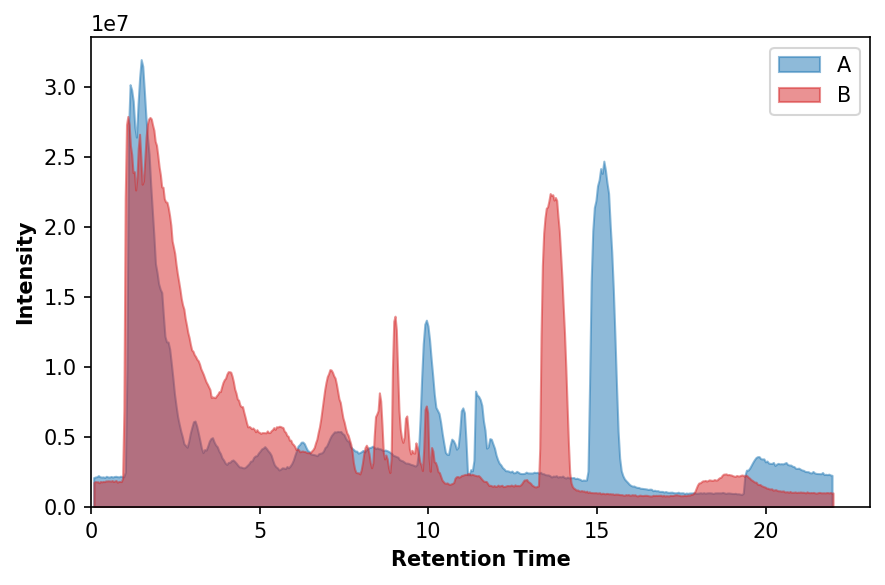

In [5]:
# visualize
fig, ax = plt.subplots(1, dpi=150, facecolor='w')
ax.fill_between(a_rt['retention_time'], a_rt['intensity'], color='C0', alpha=0.5, label='A')
ax.fill_between(b_rt['retention_time'], b_rt['intensity'], color='C3', alpha=0.5, label='B')

ax.set_xlabel('Retention Time', fontweight='bold')
ax.set_ylabel('Intensity', fontweight='bold')

ax.set_xlim(0, None)
ax.set_ylim(0, None)

plt.legend()
plt.tight_layout()
plt.show()

To determine putative feature correspondence by matching, we first need features.
We'll peakpick the data that has been nominally thresholded.

In [13]:
# perform peak detection
peaks = {}
peaks['A'] = deimos.peakpick.persistent_homology(deimos.threshold(data['A'], threshold=128),
                                                 dims=['mz', 'drift_time', 'retention_time'])
peaks['B'] = deimos.peakpick.persistent_homology(deimos.threshold(data['B'], threshold=128),
                                                 dims=['mz', 'drift_time', 'retention_time'])

In [14]:
# downselect by persistence
peaks['A']['persistence_ratio'] = peaks['A']['persistence'] / peaks['A']['intensity']
peaks['A'] = deimos.threshold(peaks['A'], by='persistence_ratio', threshold=0.75)

peaks['B']['persistence_ratio'] = peaks['B']['persistence'] / peaks['B']['intensity']
peaks['B'] = deimos.threshold(peaks['B'], by='persistence_ratio', threshold=0.75)

Next, we'll partition the data along the _m/z_ dimension and determine matches within tolerance (20 ppm in _m/z_, 3% in drift time, and 2 minutes in retention time).
Retention time tolerance is intentionally large to account for potential nonlinearities.
Thresholding is again applied as to prevent low intensity features from influencing the result.

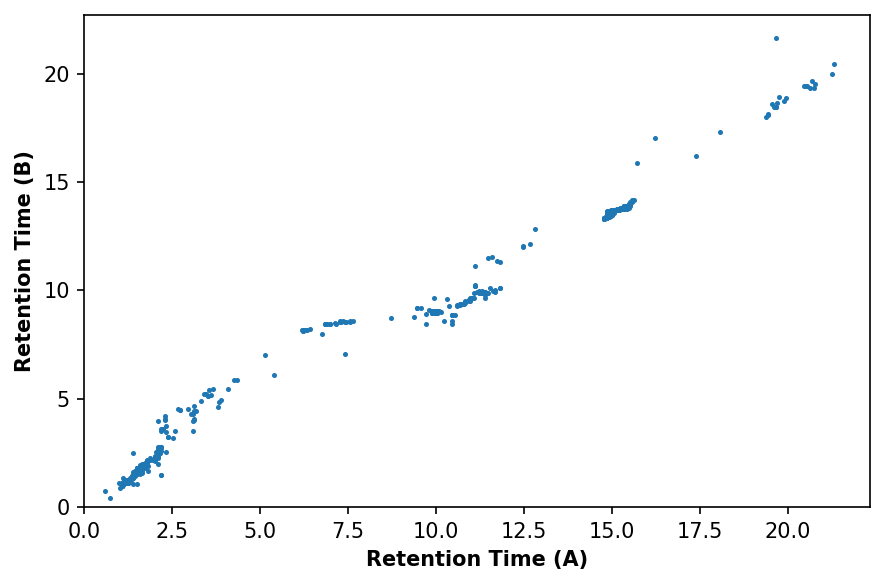

In [21]:
# partition
partitions = deimos.partition(deimos.threshold(peaks['A'], threshold=1E3),
                              split_on='mz',
                              size=1000,
                              overlap=0.25)

# match
a_matched, b_matched = partitions.zipmap(deimos.alignment.match, deimos.threshold(peaks['B'], threshold=1E3),
                                         dims=['mz', 'drift_time', 'retention_time'],
                                         tol=[20E-6, 0.03, 2], relative=[True, True, False],
                                         processes=4)

# visualize
fig, ax = plt.subplots(1, dpi=150, facecolor='w')
ax.scatter(a_matched['retention_time'], b_matched['retention_time'], s=2)

ax.set_xlabel('Retention Time (A)', fontweight='bold')
ax.set_ylabel('Retention Time (B)', fontweight='bold')

ax.set_xlim(0, None)
ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

Once features are matched, we can model the relationship between samples using support vector regression (SVR) as implemented in scikit-learn.
While SVR was selected here for its broad applicability to both linear and nonlinear alignment, many approaches have been successfully developed in this space, and SVR is not necessarily superior.

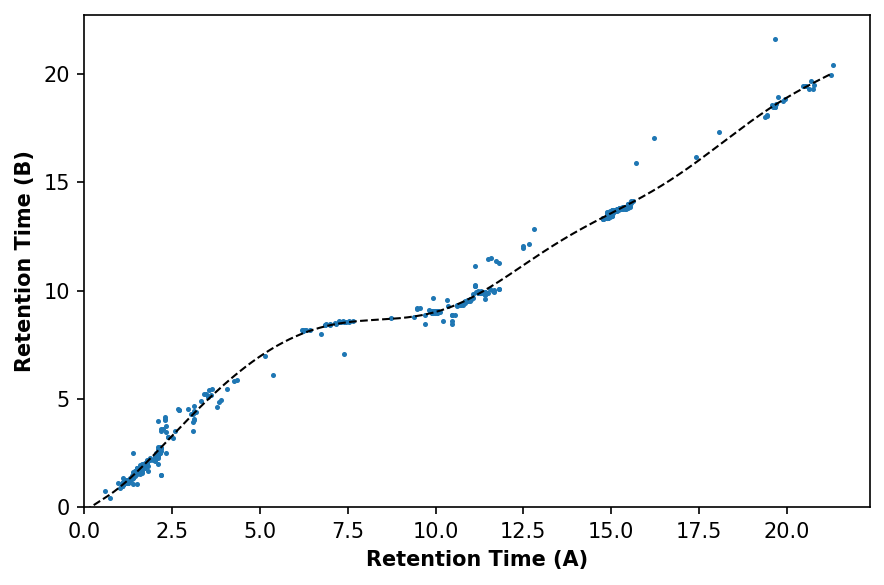

In [27]:
# svr spline
spl = deimos.alignment.fit_spline(a_matched, b_matched, align='retention_time', kernel='rbf', C=1000)
newx = np.linspace(0, a_matched['retention_time'].max(), 1000)

# visualize
fig, ax = plt.subplots(1, dpi=150, facecolor='w')
ax.plot(newx, spl(newx), c='black', linewidth=1, linestyle='--')
ax.scatter(a_matched['retention_time'], b_matched['retention_time'], s=2)

ax.set_xlabel('Retention Time (A)', fontweight='bold')
ax.set_ylabel('Retention Time (B)', fontweight='bold')

ax.set_xlim(0, None)
ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

Next we'll apply the alignment and replot the total ion chromatograms.

In [24]:
data['A_'] = data['A'].copy()
data['A_']['retention_time'] = spl(data['A_']['retention_time'])

In [25]:
# collapse
a_rt_ = deimos.collapse(data['A_'], keep='retention_time').sort_values(by='retention_time')

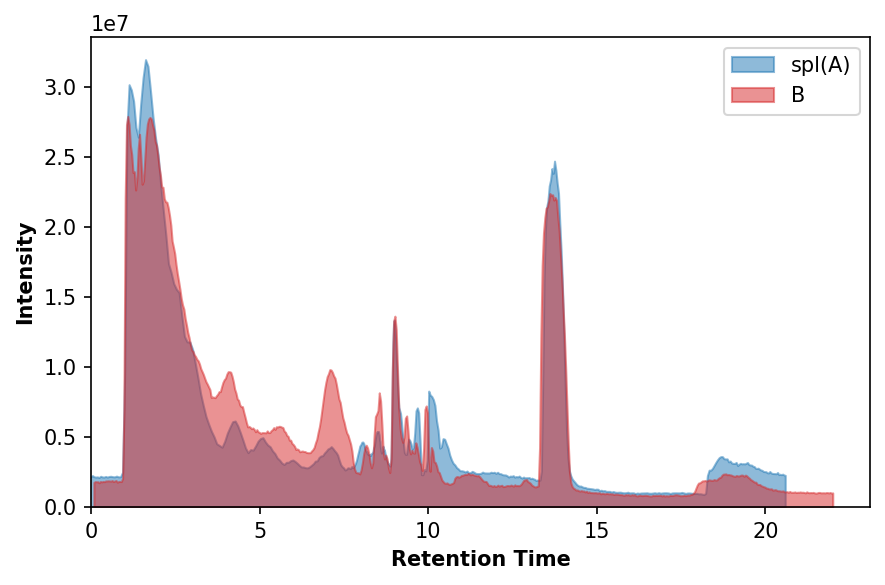

In [26]:
# visualize
fig, ax = plt.subplots(1, dpi=150, facecolor='w')
ax.fill_between(a_rt_['retention_time'], a_rt_['intensity'], color='C0', alpha=0.5, label='spl(A)')
ax.fill_between(b_rt['retention_time'], b_rt['intensity'], color='C3', alpha=0.5, label='B')

ax.set_xlabel('Retention Time', fontweight='bold')
ax.set_ylabel('Intensity', fontweight='bold')

ax.set_xlim(0, None)
ax.set_ylim(0, None)

plt.legend()
plt.tight_layout()
plt.show()

## Cross-sample Alignment

Agglomerative clustering is implemented via scikit-learn using a custom distance matrix to ensure the maximum linkage distance does not exceed the user-specified tolerance in any one dimension, i.e. Chebyshev distance or L-infinity norm.
Cluster affinity is defined by complete linkage, which uses the maximum of the distances between all observations of two sets to qualify a merge.
To ensure that features are merged into clusters across datasets, not within, a connectivity matrix is automatically generated to mask intrasample linkages.
However, intra-dataset clustering can occur when parent nodes unconstrained by the connectivity matrix are merged, resulting in the clustering of distal, nonadjacent child nodes.
We note that nodes are not merged if the maximum linkage distance is exceeded. Thus, to prevent erroneous feature merges, the user can simply reduce their selected tolerances.